In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import rankdata

**Not sure if this is a bump-chart**

https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-05-04/readme.md

In [2]:
data_raw = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-04/water.csv")

In [3]:
data = (
    data_raw
    .dropna(subset=["install_year", "country_name"])
    .assign(
        install_decade = (data_raw["install_year"] // 10) * 10,
    )
    .query("1970 <= install_decade <= 2020")
)

data["nb_install"] = data.groupby(["country_name", "install_decade"])["country_name"].transform("size") 

data_pivoted = pd.pivot_table(
    data, index="country_name", values="nb_install", columns="install_decade"
).dropna().reset_index()

data = pd.melt(data_pivoted, id_vars = "country_name", value_name="nb_install", var_name="decade")
data["country_name"] = data["country_name"].str.upper()
data["rank"] = data.groupby("decade")["nb_install"].transform(lambda x: rankdata(-x))
data = data.sort_values(["country_name", "decade"])
data

,country_name,decade,nb_install,rank
0,ETHIOPIA,1970.0,1.0,12.0
12,ETHIOPIA,1980.0,38.0,11.0
24,ETHIOPIA,1990.0,405.0,11.0
36,ETHIOPIA,2000.0,15132.0,3.0
48,ETHIOPIA,2010.0,4911.0,6.0
...,...,...,...,...
23,ZIMBABWE,1980.0,4055.0,2.0
35,ZIMBABWE,1990.0,5257.0,4.0
47,ZIMBABWE,2000.0,2338.0,8.0
59,ZIMBABWE,2010.0,3334.0,7.0


In [4]:
data_bis = data.assign(country = data["country_name"]).drop("country_name", axis=1)

In [5]:
decades = data[data["country_name"] == "ETHIOPIA"]["decade"].values
ranks = data[data["country_name"] == "ETHIOPIA"]["rank"].values

In [6]:
COUNTRIES = data["country_name"].unique()
COUNTRIES

array(['ETHIOPIA', 'GHANA', 'KENYA', 'LIBERIA', 'NIGERIA', 'PERU',
       'RWANDA', 'SWAZILAND', 'TANZANIA', 'UGANDA', 'ZAMBIA', 'ZIMBABWE'],
      dtype=object)

In [9]:
def add_label(x, y, ax):
    ax.annotate(
        f"#{int(y)} in\n{str(int(x))[2:]}s", 
        xy=(x, y - 0.4), 
        xycoords="data",
        ha="center", 
        va="bottom",
        fontsize=10,
        fontname="Lato",
        zorder=12
    )

In [10]:
def plot_country(country, data, annotate, ax):
    
    for country_inner in COUNTRIES:
        d = data[data["country_name"] == country_inner] 
        x = d["decade"].values
        y = d["rank"].values

        if country_inner == country:
            ax.plot(x, y, color="#0b53c1", lw=2.4, zorder=10)
            ax.scatter(x, y, fc="w", ec="#0b53c1", s=60, lw=2.4, zorder=12)
            if annotate:
                add_label(x[0], y[0], ax)
                add_label(x[-1], y[-1], ax)
        else:
            ax.plot(x, y, color="#BFBFBF", lw=1.5)

    ax.set_yticks([])
    ax.set_xticks([1970, 1980, 1990, 2000, 2010, 2020])
    ax.set_xticklabels(
        ["70s", "80s", "90s", "00s", "10s", "20s"], 
        fontsize=8,
        fontfamily="Inconsolata"
    )
    ax.tick_params(bottom=False)
    ax.set_frame_on(False)

    ax.set_title(country, fontfamily="Inconsolata", fontsize=14, fontweight=500)
    
    return ax

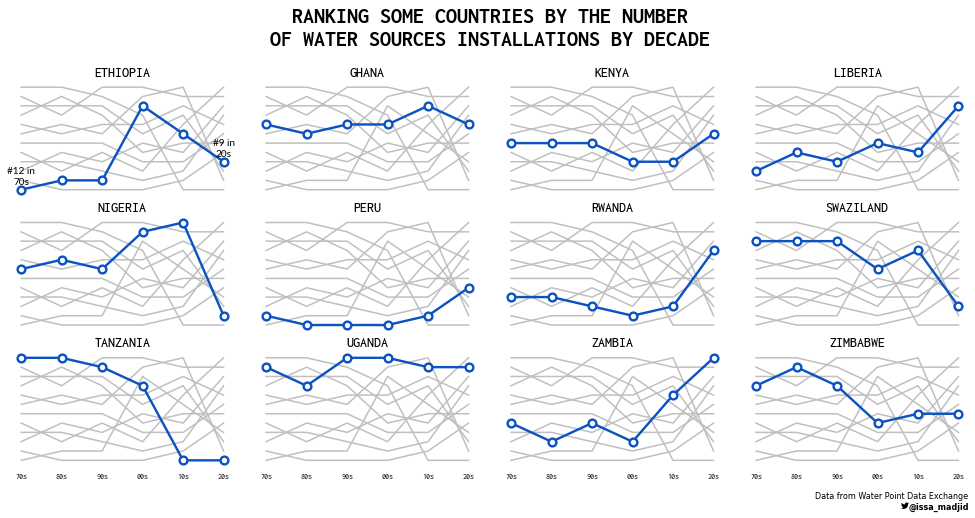

In [32]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 7.5))

fig.subplots_adjust(wspace=0.1, left=0.025, right=0.975, bottom=0.11, top=0.82)

for idx, (ax, country) in enumerate(zip(axes.ravel(), COUNTRIES)):
    annotate = idx == 0
    plot_country(country, data, annotate, ax)

ax.invert_yaxis()

fig.text(
    x=0.5, 
    y=0.92,
    s="RANKING SOME COUNTRIES BY THE NUMBER\nOF WATER SOURCES INSTALLATIONS BY DECADE",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold",
    fontname="Inconsolata"
)

fig.text(
    x=0.975,
    y=0.05,
    s="Data from Water Point Data Exchange",
    ha="right",
    ma="right",
    fontsize=8
)

twitter_symbol = "\uf099"

fig.text(
    x=0.975,
    y=0.03,
    s="@issa_madjid",
    ha="right",
    ma="right",
    fontsize=8,
    fontweight="bold", 
)

fig.text(
    x=0.915,
    y=0.03,
    s=twitter_symbol,
    ha="right",
    ma="right",
    fontsize=8,
    fontweight="bold",
    fontfamily="Font Awesome 5 Brands"
)

fig.savefig("plot.png", facecolor="white", dpi=300)

* https://fontawesome.com/v5/cheatsheet/free/brands
* https://stackoverflow.com/questions/52902086/how-to-use-font-awesome-symbol-as-marker-in-matplotlib
